# Hierarchical Classification - Stage 1: Coarse Anatomical Region Training

This notebook trains **only Stage 1 (Coarse Classifier)** of the hierarchical classification model.

## Training Pipeline
- **Stage 1 (This Notebook)**: Train coarse classifier to predict anatomical regions (abdomen, chest, brain)
- **Stage 2 (Separate Notebook)**: Load trained Stage 1, train region-specific fine classifiers

## Datasets
- **OrganMNIST3D** (11 classes, multi-region)
- **NoduleMNIST3D** (2 classes, chest)
- **AdrenalMNIST3D** (2 classes, abdomen)
- **FractureMNIST3D** (3 classes, chest)
- **VesselMNIST3D** (2 classes, brain)

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset
from utils.hierarchical_model import HierarchicalClassificationModel

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Device: cuda


## 1. Load Merged Dataset

In [2]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print("\n" + "="*60)
print("MERGED DATASET INFO")
print("="*60)
print(f"Datasets: {dataset_info['datasets_included']}")
print(f"Train samples: {dataset_info['train_samples']:,}")
print(f"Val samples: {dataset_info['val_samples']:,}")
print(f"Test samples: {dataset_info['test_samples']:,}")
print(f"\nCoarse classes (regions): {dataset_info['num_coarse_classes']}")
print(f"Region mapping: {dataset_info['idx_to_region']}")
print(f"Fine classes: {dataset_info['num_fine_classes']}")

Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verif

In [3]:
# Verify data format
print("\nVerifying data format...")
for imgs, coarse_labels, fine_labels in train_loader:
    print(f"  Image shape: {imgs.shape}")
    print(f"  Coarse labels: {coarse_labels.shape} - unique: {coarse_labels.unique().tolist()}")
    print(f"  Fine labels: {fine_labels.shape} - unique: {fine_labels.unique().tolist()[:10]}...")
    break
print(" Data format verified!")


Verifying data format...
  Image shape: torch.Size([16, 1, 28, 28, 28])
  Coarse labels: torch.Size([16]) - unique: [0, 1, 2]
  Fine labels: torch.Size([16]) - unique: [0, 1, 2, 3, 4, 5, 8]...
 Data format verified!


## 2. Build Hierarchical Model

In [4]:
# Configure region-specific classes
region_configs = dataset_info['region_num_classes']
region_idx_to_name = dataset_info['idx_to_region']

print("Region configurations:")
for region, num_classes in region_configs.items():
    print(f"  {region}: {num_classes} classes")

Region configurations:
  abdomen: 10 classes
  chest: 8 classes
  brain: 2 classes


In [5]:
# Create hierarchical model
model = HierarchicalClassificationModel(
    region_configs=region_configs,
    architecture=MODEL_CONFIG['architecture'],
    coarse_model_type=MODEL_CONFIG['coarse_architecture'],
    fine_model_type=MODEL_CONFIG['fine_architecture'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    region_idx_to_name=region_idx_to_name,
    num_total_organs=dataset_info['num_fine_classes'],
    use_subtypes=False
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel created:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Coarse architecture: {MODEL_CONFIG['coarse_architecture']}")
print(f"  Fine architecture: {MODEL_CONFIG['fine_architecture']}")


Model created:
  Total parameters: 22,321,943
  Trainable parameters: 22,321,943
  Coarse architecture: densenet121_3d
  Fine architecture: densenet121_3d


## 3. Train Stage 1: Coarse Classifier Only

This stage trains only the coarse (anatomical region) classifier. The fine classifiers will be trained separately in Stage 2.

## Stage 1 Results Summary

In [6]:
def train_stage1(model, train_loader, val_loader, device, epochs, lr):
    """Train only Stage 1 (Coarse Classifier)."""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=TRAINING_CONFIG['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=TRAINING_CONFIG['scheduler_step_size'], 
        gamma=TRAINING_CONFIG['scheduler_gamma']
    )
    
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    # Freeze fine components if needed (though here we just train coarse)
    # The model's forward_coarse only uses the backbone + coarse heads
    
    print(f"Starting Stage 1 training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for imgs, coarse_labels, _ in pbar:
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            coarse_labels = coarse_labels.long().to(device)
            
            optimizer.zero_grad()
            coarse_logits = model.forward_coarse(imgs)
            loss = criterion(coarse_logits, coarse_labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
            preds = coarse_logits.argmax(1)
            correct += (preds == coarse_labels).sum().item()
            total += imgs.size(0)
            
            pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
            
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for imgs, coarse_labels, _ in val_loader:
                imgs = imgs.to(device, dtype=torch.float32)
                if imgs.max() > 1:
                    imgs = imgs / 255.0
                coarse_labels = coarse_labels.long().to(device)
                
                coarse_logits = model.forward_coarse(imgs)
                loss = criterion(coarse_logits, coarse_labels)
                
                val_loss += loss.item() * imgs.size(0)
                preds = coarse_logits.argmax(1)
                val_correct += (preds == coarse_labels).sum().item()
                val_total += imgs.size(0)
        
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
    return history, best_val_acc


In [7]:
# Train Stage 1
history, best_val_acc = train_stage1(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=TRAINING_CONFIG['coarse_epochs'],
    lr=TRAINING_CONFIG['learning_rate']
)

print("\n" + "="*60)
print("STAGE 1 TRAINING COMPLETE!")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Model saved to: {PATHS['models']}/hierarchical-classifiers/{MODEL_CONFIG['architecture']}/stage1_coarse_model.pth")

Starting Stage 1 training for 20 epochs...


Epoch 1/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 24.13it/s, loss=0.349, acc=0.862]


Epoch 1/20 - Train Loss: 0.3490, Train Acc: 0.8619, Val Loss: 0.1727, Val Acc: 0.9304


Epoch 2/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.48it/s, loss=0.209, acc=0.924]


Epoch 2/20 - Train Loss: 0.2088, Train Acc: 0.9245, Val Loss: 0.3751, Val Acc: 0.8384


Epoch 3/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 24.37it/s, loss=0.181, acc=0.939]


Epoch 3/20 - Train Loss: 0.1810, Train Acc: 0.9387, Val Loss: 0.1766, Val Acc: 0.9290


Epoch 4/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.86it/s, loss=0.138, acc=0.952]


Epoch 4/20 - Train Loss: 0.1382, Train Acc: 0.9523, Val Loss: 0.0426, Val Acc: 0.9861


Epoch 5/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.65it/s, loss=0.137, acc=0.953]


Epoch 5/20 - Train Loss: 0.1368, Train Acc: 0.9528, Val Loss: 0.0495, Val Acc: 0.9819


Epoch 6/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.59it/s, loss=0.117, acc=0.961]


Epoch 6/20 - Train Loss: 0.1169, Train Acc: 0.9611, Val Loss: 0.0681, Val Acc: 0.9791


Epoch 7/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 23.77it/s, loss=0.0896, acc=0.968]


Epoch 7/20 - Train Loss: 0.0896, Train Acc: 0.9685, Val Loss: 0.0468, Val Acc: 0.9805


Epoch 8/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 24.37it/s, loss=0.113, acc=0.967]


Epoch 8/20 - Train Loss: 0.1127, Train Acc: 0.9671, Val Loss: 0.0541, Val Acc: 0.9819


Epoch 9/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.76it/s, loss=0.0852, acc=0.971]


Epoch 9/20 - Train Loss: 0.0852, Train Acc: 0.9709, Val Loss: 0.0385, Val Acc: 0.9875


Epoch 10/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 24.89it/s, loss=0.129, acc=0.959]


Epoch 10/20 - Train Loss: 0.1293, Train Acc: 0.9588, Val Loss: 0.0457, Val Acc: 0.9861


Epoch 11/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.67it/s, loss=0.0652, acc=0.979]


Epoch 11/20 - Train Loss: 0.0652, Train Acc: 0.9794, Val Loss: 0.0583, Val Acc: 0.9819


Epoch 12/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 24.98it/s, loss=0.0576, acc=0.979]


Epoch 12/20 - Train Loss: 0.0576, Train Acc: 0.9792, Val Loss: 0.0263, Val Acc: 0.9916


Epoch 13/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.85it/s, loss=0.0567, acc=0.98] 


Epoch 13/20 - Train Loss: 0.0567, Train Acc: 0.9801, Val Loss: 0.0559, Val Acc: 0.9777


Epoch 14/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 25.21it/s, loss=0.0517, acc=0.983]


Epoch 14/20 - Train Loss: 0.0517, Train Acc: 0.9826, Val Loss: 0.0275, Val Acc: 0.9930


Epoch 15/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 24.28it/s, loss=0.0556, acc=0.981]


Epoch 15/20 - Train Loss: 0.0556, Train Acc: 0.9810, Val Loss: 0.0217, Val Acc: 0.9889


Epoch 16/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 25.13it/s, loss=0.0525, acc=0.981]


Epoch 16/20 - Train Loss: 0.0525, Train Acc: 0.9812, Val Loss: 0.0293, Val Acc: 0.9916


Epoch 17/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.48it/s, loss=0.0643, acc=0.98] 


Epoch 17/20 - Train Loss: 0.0643, Train Acc: 0.9797, Val Loss: 0.0270, Val Acc: 0.9916


Epoch 18/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.48it/s, loss=0.0507, acc=0.985]


Epoch 18/20 - Train Loss: 0.0507, Train Acc: 0.9854, Val Loss: 0.0205, Val Acc: 0.9944


Epoch 19/20 [Train]: 100%|██████████| 355/355 [00:13<00:00, 25.48it/s, loss=0.0553, acc=0.981]


Epoch 19/20 - Train Loss: 0.0553, Train Acc: 0.9810, Val Loss: 0.0956, Val Acc: 0.9763


Epoch 20/20 [Train]: 100%|██████████| 355/355 [00:14<00:00, 25.04it/s, loss=0.0507, acc=0.981]


Epoch 20/20 - Train Loss: 0.0507, Train Acc: 0.9812, Val Loss: 0.0339, Val Acc: 0.9861

STAGE 1 TRAINING COMPLETE!
Best Validation Accuracy: 0.9944
Model saved to: /home/luca/HierarchicalMIC/models/stage1_coarse_densenet121_3d.pth


In [8]:
architecture = MODEL_CONFIG['architecture']
# Display Stage 1 training results
print("=" * 80)
print("STAGE 1 TRAINING COMPLETE - Coarse (Region) Classification")
print("=" * 80)
print(f"Architecture: {architecture}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Number of Regions: {dataset_info['num_coarse_classes']}")
print(f"\nRegion Mapping:")
for idx, region in dataset_info['idx_to_region'].items():
    print(f"  {idx}: {region}")
print("\n" + "=" * 80)


STAGE 1 TRAINING COMPLETE - Coarse (Region) Classification
Architecture: densenet121_3d
Best Validation Accuracy: 0.9944
Number of Regions: 3

Region Mapping:
  0: abdomen
  1: chest
  2: brain



In [9]:
import json
from pathlib import Path
# Create save directory
architecture = MODEL_CONFIG['architecture']
save_dir = Path(PATHS['models']) / 'hierarchical-classifiers' / architecture
save_dir.mkdir(parents=True, exist_ok=True)

# Save Stage 1 model
model_path = save_dir / 'stage1_coarse_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Stage 1 model saved to: {model_path}")

# Prepare comprehensive metrics
stage1_metrics = {
    "model_type": "hierarchical_stage1",
    "architecture": architecture,
    "coarse_accuracy": float(best_val_acc),
    "num_regions": dataset_info['num_coarse_classes'],
    "region_mapping": dataset_info['idx_to_region'],
    "training_history": {
        "best_val_acc": float(best_val_acc),
        "final_train_loss": float(history['train_loss'][-1]) if history['train_loss'] else None,
        "epochs_trained": len(history['train_loss'])
    }
}

# Save Stage 1 info (for loading in Stage 2)
info_path = save_dir / 'stage1_info.json'
with open(info_path, 'w') as f:
    json.dump({
        "architecture": architecture,
        "model_path": str(model_path),
        "best_val_accuracy": float(best_val_acc),
        "region_configs": region_configs,
        "region_idx_to_name": region_idx_to_name
    }, f, indent=2)
print(f"Stage 1 info saved to: {info_path}")

# Save detailed metrics
metrics_path = save_dir / 'stage1_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(stage1_metrics, f, indent=2)
print(f"Stage 1 metrics saved to: {metrics_path}")

print(f"\nAll Stage 1 outputs saved to: {save_dir}")


Stage 1 model saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d/stage1_coarse_model.pth
Stage 1 info saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d/stage1_info.json
Stage 1 metrics saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d/stage1_metrics.json

All Stage 1 outputs saved to: /home/luca/HierarchicalMIC/models/hierarchical-classifiers/densenet121_3d


In [10]:
# Training configuration
print(f"Training configuration:")
print(f"  Coarse epochs: {TRAINING_CONFIG['coarse_epochs']}")
print(f"  Learning rate: {TRAINING_CONFIG['learning_rate']}")

Training configuration:
  Coarse epochs: 20
  Learning rate: 0.001


## 4. Training Visualization

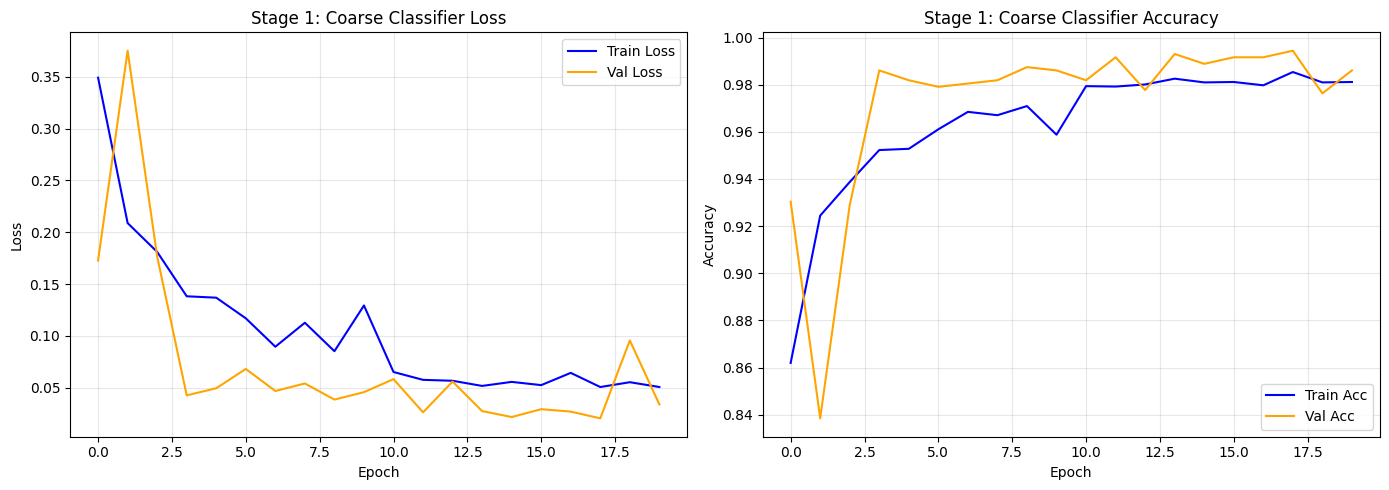

In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Stage 1: Coarse Classifier Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Stage 1: Coarse Classifier Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PATHS['figures']}/stage1_coarse_training_{MODEL_CONFIG['architecture']}.png", dpi=150)
plt.show()

## 5. Evaluation on Test Set (Coarse Only)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load best model for evaluation
from pathlib import Path
save_dir = Path(PATHS['models']) / 'hierarchical-classifiers' / MODEL_CONFIG['architecture']
model.load_state_dict(torch.load(save_dir / 'stage1_coarse_model.pth'))
model.eval()

# Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, coarse_labels, _ in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(DEVICE, dtype=torch.float32)
        if imgs.max() > 1:
            imgs = imgs / 255.0
        coarse_labels = coarse_labels.long().to(DEVICE)
        
        coarse_logits = model.forward_coarse(imgs)
        preds = coarse_logits.argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(coarse_labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute metrics
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\n" + "="*60)
print("STAGE 1 TEST RESULTS")
print("="*60)
print(f"\n{'Metric':<15} {'Value':<10}")
print("-" * 25)
print(f"{'Accuracy':<15} {test_acc:.4f}")
print(f"{'Precision':<15} {test_precision:.4f}")
print(f"{'Recall':<15} {test_recall:.4f}")
print(f"{'F1-Score':<15} {test_f1:.4f}")
print(f"\nCorrectly classified {int(test_acc * len(all_labels))}/{len(all_labels)} samples")

/tmp/ipykernel_122224/13384162.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_dir / 'stage1_coarse_model.pth'))
Testing: 100%|████


STAGE 1 TEST RESULTS

Metric          Value     
-------------------------
Accuracy        0.9755
Precision       0.9759
Recall          0.9755
F1-Score        0.9755

Correctly classified 1795/1840 samples


In [13]:
# Per-region accuracy
from collections import defaultdict

region_correct = defaultdict(int)
region_total = defaultdict(int)

for pred, label in zip(all_preds, all_labels):
    region_name = region_idx_to_name[label]
    region_total[region_name] += 1
    if pred == label:
        region_correct[region_name] += 1

print("\nPer-Region Coarse Classification Accuracy:")
for region_name in region_idx_to_name.values():
    if region_total[region_name] > 0:
        acc = region_correct[region_name] / region_total[region_name]
        print(f"  {region_name}: {acc:.4f} ({region_correct[region_name]}/{region_total[region_name]})")


Per-Region Coarse Classification Accuracy:
  abdomen: 0.9785 (820/838)
  chest: 0.9565 (593/620)
  brain: 1.0000 (382/382)


## 6. Save Model Information for Stage 2

In [14]:
# Save configuration for Stage 2 to use
import json

stage1_info = {
    'model_path': f"{PATHS['models']}/hierarchical-classifiers/{MODEL_CONFIG['architecture']}/stage1_coarse_model.pth",
    'architecture': MODEL_CONFIG['architecture'],
    'coarse_architecture': MODEL_CONFIG['coarse_architecture'],
    'fine_architecture': MODEL_CONFIG['fine_architecture'],
    'dropout_rate': MODEL_CONFIG['dropout_rate'],
    'region_configs': region_configs,
    'region_idx_to_name': region_idx_to_name,
    'num_fine_classes': dataset_info['num_fine_classes'],
    'test_accuracy': test_acc,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'best_val_accuracy': best_val_acc
}

with open(f"{PATHS['models']}/stage1_info_{MODEL_CONFIG['architecture']}.json", 'w') as f:
    json.dump(stage1_info, f, indent=2)

print(f"Stage 1 information saved to: {PATHS['models']}/stage1_info_{MODEL_CONFIG['architecture']}.json")
print("\nNow run 03b_stage2_fine_training.ipynb to train the fine classifiers.")

Stage 1 information saved to: /home/luca/HierarchicalMIC/models/stage1_info_densenet121_3d.json

Now run 03b_stage2_fine_training.ipynb to train the fine classifiers.
